## Домашнее задание №7

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

### Задача №1: 
Обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку первого занятия.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

Text(0.5, 1.0, 'Image label: 5')

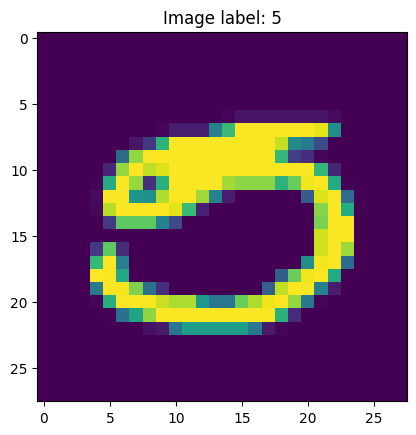

In [2]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)


random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 92% accuracy.

*Комментарий: для этого достаточно линейных слоев и функций активации.*

__Внимание, ваша модель должна быть представлена именно переменной `model`.__

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 50) 
        self.final = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x

model = Model()    
model.to("cuda:0")

Model(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

Локальные тесты для проверки вашей модели доступны ниже:

In [4]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]
    # compute outputs given inputs, both are variables
    y_predicted = model(x.to("cuda:0"))    
except Exception as e:
    print('Something is wrong with the model')
    raise e
    
    
assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Рекомендуем поработать с различными оптимизаторами.

In [11]:
cross_el = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #e-1
epoch = 10
for epoch in range(epoch):
    model.train()

    for data in train_data_loader:
        x, y = data
        optimizer.zero_grad()
        output = model(x.view(-1, 28*28).to("cuda:0"))
        loss = cross_el(output, y.to("cuda:0"))
        loss.backward()
        optimizer.step()

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [14]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784).to("cuda:0"))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels.to("cuda:0")).type(torch.FloatTensor).mean()

In [15]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.99408


In [18]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784).to("cuda:0"))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels.to("cuda:0")).type(torch.FloatTensor).mean()

In [19]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9758


Проверка, что необходимые пороги пройдены:

In [20]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

### Сдача задания
Загрузите файл `hw07_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23s_dd_ml/homeworks/hw07_mnist_classification/hw07_data_dict.npy

In [ ]:
# do not change the code in the block below
# __________start of block__________
import os

assert os.path.exists('hw07_data_dict.npy'), 'Please, download `hw07_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):
    
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))
    
    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels

loaded_data_dict = np.load('hw07_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])).numpy(),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test'])).numpy()
}

np.save('submission_dict_hw07.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw07.npy`')
# __________end of block__________

На этом задание завершено. Поздравляем!